# RANS from DNS

Our goal here, in general, is to find new valid equations that describe fluid flow. 
We will try to find new closures for the steady RANS equations based on direct numerical
simulation (DNS) of a boundary layer.


## Steady RANS equations with generic Reynolds stress effects

$$
(\vec{U} \cdot \nabla) \vec{U}
+ \frac{1}{\rho} \nabla P 
- \nu \nabla^2 \vec{U}
= \mathbf{R},
$$

where in this case $\mathbf{R}$ is simply the effects of the Reynolds stresses (i.e., the opposite of the gradient), not the Reynolds stresses themselves.

Some ideas for what $\mathbf{R}$ could be:

$$
\mathbf{R} = A\nabla P^2 + B\nabla K + C \nabla \times \vec{U} 
    + D\nabla(\nabla \times \vec{U})^2
    + E \vec{U}
$$


## Algorithm

1. Pick terms (in addition to non-Reynolds stress Navier--Stokes terms).
2. Create a random list of points in space that is at least as large as the number
   of terms.
3. At each point, acquire all data for all terms for all times.
4. Average data at each point for all times.
5. Solve for coefficients using a linear model.

## Terms

$$
U \frac{\partial U}{\partial x} 
+ V \frac{\partial U}{\partial y} + W \frac{\partial U}{\partial z}
+ \frac{1}{\rho}\frac{\partial P}{\partial x} 
- \nu \left( 
    \frac{\partial^2 U}{\partial x^2}
    + \frac{\partial^2 U}{\partial y^2} 
    + \frac{\partial^2 U}{\partial z^2} 
\right)
$$

$$
= 
A \left( \frac{\partial U}{\partial x} \right)^2 
+ B \left( \frac{\partial U}{\partial y} \right)^2
+ C \left( \frac{\partial U}{\partial z} \right)^2
+ D \left( \frac{\partial P}{\partial x} \right)^2
+ E \frac{\partial^2 P}{\partial x^2}
+ F U \frac{\partial P}{\partial x}
$$

$$
U \frac{\partial V}{\partial x} 
+ V \frac{\partial V}{\partial y} 
+ W \frac{\partial V}{\partial z}
+ \frac{1}{\rho}\frac{\partial P}{\partial y} 
- \nu \left( 
    \frac{\partial^2 V}{\partial x^2}
    + \frac{\partial^2 V}{\partial y^2} 
    + \frac{\partial^2 V}{\partial z^2} 
\right)
$$

$$
= 
A \left( \frac{\partial V}{\partial x} \right)^2 
+ B \left( \frac{\partial V}{\partial y} \right)^2
+ C \left( \frac{\partial V}{\partial z} \right)^2
+ D \left( \frac{\partial P}{\partial y} \right)^2
+ E \frac{\partial^2 P}{\partial y^2}
+ F V \frac{\partial P}{\partial y}
$$

## Terms in index notation

To be general and consistent, since we don't have any x- or z-variation

$$
\frac{\partial U_i}{\partial t} + U_j \frac{\partial U_i}{\partial x_j} 
+ \frac{1}{\rho}\frac{\partial P}{\partial x_i}
- \nu \frac{\partial ^2 U_i}{\partial x_j x_j}
=
A \frac{(\partial U_i)^2}{\partial x_j \partial x_j}
+ B \frac{\partial U_j U_j}{\partial x_i}
+ C \frac{\partial P^2}{\partial x_i}
+ D \left( \frac{\partial P}{\partial x_i} \right)^2
+ E U_j \frac{\partial P}{\partial x_j}
$$

What these coefficients describe:

* $A$: The square of the velocity gradient
* $B$: The gradient of kinetic energy
* $C$: The gradient of squared pressure
* $D$: The square of the pressure gradient

,y/d99,y+,uv,uw,vw,umed,vmed,wmed,dumdy,dvmdy,dwmdy,oxmed,oymed,ozmed,pm,pp,y
y,,,,,,,,,,,,,,,,,
0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,1.000017,-4.849432e-10,-0.001014,-0.001014,0.000000e+00,-1.000017,0.000529,3.032713,0.000000
0.002241,0.000145,0.288859,-0.000027,-0.000020,3.663793e-08,0.288859,5.517880e-08,-0.000293,0.999980,3.826547e-07,-0.001014,-0.001014,-5.526411e-08,-0.999980,0.000529,3.030068,0.002241
0.005143,0.000333,0.662932,-0.000337,-0.000110,4.568896e-07,0.662892,2.913277e-07,-0.000672,0.999738,8.802282e-07,-0.001014,-0.001014,-1.268852e-07,-0.999738,0.000529,3.028187,0.005143
0.008698,0.000564,1.121292,-0.001671,-0.000327,2.301801e-06,1.120913,8.350829e-07,-0.001137,0.998564,1.492937e-06,-0.001012,-0.001012,-2.148001e-07,-0.998564,0.000528,3.027302,0.008698
0.012900,0.000836,1.663030,-0.005539,-0.000751,7.686887e-06,1.661029,1.840536e-06,-0.001684,0.994960,2.218613e-06,-0.001007,-0.001007,-3.188665e-07,-0.994960,0.000528,3.027948,0.012900


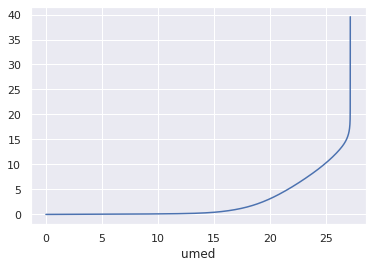

In [38]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn
seaborn.set()

# Write a function to load the data
def load_data(re=6500, drop_aux_cols=True):
    fpath = f"data/jiminez/Re_theta.{re:4d}.prof"
    # First read delta 99 and column names
    with open(fpath) as f:
        for n, line in enumerate(f.readlines()):
            line = line.split()
            if len(line) > 1:
                if line[1].startswith("delta_99="):
                    d99 = float(line[1].replace("delta_99=", ""))
                elif line[1].startswith("y/d99"):
                    cols = line[1:]
                    skiprows = n + 1
    df = pd.read_csv(fpath, names=cols, skiprows=skiprows,
                     delim_whitespace=True)
    df["y"] = df["y/d99"] * d99
    # Drop columns we won't be using
    if drop_aux_cols:
        df = df[[c for c in df.columns if "rms" not in c
                 and "3" not in c and "2" not in c]]
    return df.set_index("y", drop=False)


df = load_data()

df.plot(x="umed", y="y", legend=False)

df.head()

## Using data from pyJHTDB

1. Pick a bunch of points randomly throughout the domain, at least more than the number of terms we want to test.
2. Add points in each direction for computing spatial derivatives.
3. Get $\vec{u}$, $p$, and their gradients for all time at all points in the list.
4. Calculate terms based on mean values.
5. Use a regression model to determine coefficients on each term.
6. Repeat this process to ensure the coefficients don't change?
7. Run a RANS simulation with this new model and check the results against the mean profiles.

In [2]:
%load_ext blackcellmagic

In [20]:
import pyJHTDB

# Get velocity and pressure gradients and Hessians for all points and time average

# Adapted from example notebook

# Note my token is in my home directory at ~/.config/JHTDB/auth_token.txt

# load shared library
lTDB = pyJHTDB.libJHTDB()
# initialize webservices
lTDB.initialize()

dataset = "transition_bl"

spatialInterp = 0  # no spatial interpolation
temporalInterp = 0  # no time interpolation
FD4NoInt = 40  # 4th-order FD, no spatial interpolation

# Database domain size and number of grid points
x_min = 30.2185
x_max = 1000.0650
y_min = 0.0036
y_max = 26.4880
z_min = 0.0000
z_max = 240.0000
d99i = 0.9648
d99f = 15.0433

nx = 3320
ny = 224
nz = 2048

# Database time duration
Ti = 0
Tf = Ti + 1175
dt = 0.25

# Create surface
# nix = round(nx / 4)
# niz = round(nz / 4)
nix = 10
niy = 10
niz = 1
x = np.linspace(x_min, x_max, nix)
# z = np.linspace(z_min, z_max, niz)
z = np.array([120.0])
# y = d99i
y = np.linspace(y_min, y_max, niy)

[X, Y] = np.meshgrid(x, y)
points = np.zeros((nix, niy, 3))
points[:, :, 0] = X.transpose()
points[:, :, 1] = Y.transpose()
points[:, :, 2] = 120.0
# points[:, :, 2] = 120.0

# 2D array with single precision values
points = np.array(points, dtype="float32")

points.shape

(10, 10, 3)

In [34]:
%%time
# Get the velocity gradient at each point

t = Tf

print("Requesting velocity gradients at {0} points...".format(nix * niy))
result_grad = lTDB.getData(
    t,
    points,
    data_set="transition_bl",
    sinterp=FD4NoInt,
    tinterp=temporalInterp,
    getFunction="getVelocityGradient",
)

Requesting velocity gradients at 100 points...
CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 6.55 s


In [33]:
result_grad.shape

(10, 10, 9)

In [2]:
import h5py

In [3]:
with h5py.File("data/jhtdb-transitional-bl/time-ave-profiles.h5", "r") as f:
    print(f.keys())
    data = {}
    for k in f.keys():
        data[k] = f[k][()]

<KeysViewHDF5 ['pm', 'ppm', 'um', 'upm', 'uum', 'uvm', 'uwm', 'vm', 'vpm', 'vvm', 'vwm', 'wm', 'wpm', 'wwm', 'x_coor', 'y_coor', 'z_coor']>


In [14]:
x = data["x_coor"]
y = data["y_coor"]
z = data["z_coor"]
um = data["um"]
x.shape, y.shape, z.shape, um.shape

((3320,), (224,), (2048,), (224, 3320))

In [51]:
df = pd.DataFrame(columns=x, index=y, data=data["wm"])
df.columns.name = "x"
df.index.name = "y"

In [23]:
np.gradient(data["uvm"], axis=0).shape

(224, 3320)

In [56]:
# TODO: Check that RANS applies to these mean values
# If numerical derivatives are too noisy, download gradients and Hessians from JHTDB and time average
dx = np.gradient(data["x_coor"])
dy = np.reshape(np.gradient(data["y_coor"]), (224, 1))
data["dpdx"] = np.gradient(data["pm"], axis=1) / dx
data["duudx"] = np.gradient(data["uum"], axis=1) / dx
data["duvdy"] = np.gradient(data["uvm"], axis=0) / dy
data["dudx"] = np.gradient(data["um"]) / dx
data["dudy"] = (np.gradient(data["um"]) / dy)[0]

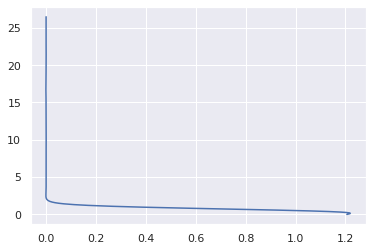

In [58]:
plt.plot(data["dudy"][:, 100], y)

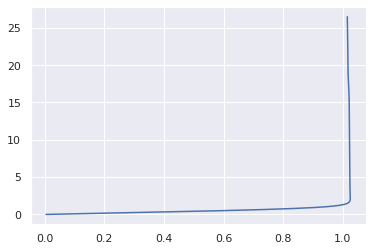

In [53]:
plt.plot(data["um"][:, 100], y)

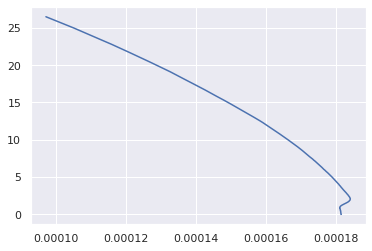

In [65]:
plt.plot(data["dpdx"][:, 100], y)

In [40]:
# TODO: Compute a bunch of quantities and add to the data dictionary
# Mean kinetic energy
# Squared gradients
# Gradients multiplied by each other
# Gradients multiplied by mean values

In [41]:
# Compute the Reynolds stress residual as a target for an ML model
# Solve a linear regression for the coefficients of all derived terms
# Throw out terms with coefficients below a threshold

In [42]:
# TODO: Write as a RANS model for OpenFOAM and solve this same problem there

In [43]:
# TODO: Check mean flow from OpenFOAM simulation matches DNS